## Constant Ductility Response Spectrum

### Import Necessary Packages and Functions

In [1]:
import numpy as np
from numpy import sqrt
from matplotlib import pyplot as plt

### Set Variable Values for System

In [2]:
## Load ground motion record
record = np.loadtxt('elcentro.txt')
record = np.array(record)*32.174049*12 #time history was given in g - so convert to in/s^2

### Linear System

In [3]:
f0=0 # magnitude of force
u0=0 #initial displacement
v0=0 # initial velocity
a0=0
ui=u0
dudti=v0
dudt2i=a0
u = [u0]
dudt = [v0]
dudt2 = [a0]
Upeak=[]
Fpeak=[]

for l in range (1,20):
    Tn=0.15*l
    wn=2*np.pi/Tn
    m=50
    k=(wn**2)*m
    xi=0.05
    c = xi*2*sqrt(m*k) # determine damping coef. from damping ratio
    wd = wn*sqrt(1.0-xi**2.0)
    ##Newmark Beta Variables - Based on Linear Acceleration Method
    gamma = 1/2
    beta = 1/6
    T1=10 #duration of motion evaluation
    dt=0.02 #time step
    N=int(T1/dt) #total number of time points
    t=np.arange(0.0,T1,dt) #generate time vector
    f = np.zeros(N)
    Df = np.zeros(N)

    ## Newmark-Beta Method (Forced)
    Kbar = k + m/(beta*(dt**2)) + c*gamma/(beta*dt)

    for i in range (1,N):
        if i < (len(record)-1):
            Dfi = -m * (record[i,1]-record[i-1,1])
        else:
            Dfi = 0
        DFbar = Dfi + ((m/(2*beta)) + c*dt*(1-gamma/(2*beta)))*dudt2i + ((1/(beta*dt))*m+(gamma/beta)*c)*dudti
        Dui = DFbar/Kbar
        Ddudt2i = (1/(beta*dt*dt))*Dui - (1/(beta*dt))*dudti - (1/(2*beta))*dudt2i
        Ddudti = dudt2i*dt+gamma*Ddudt2i*dt  
        ui = Dui + ui
        dudti = Ddudti + dudti
        dudt2i = Ddudt2i + dudt2i
        u.append(ui)
        dudt.append(dudti)
        dudt2.append(dudt2i)
    upeak = np.max(u) #peak displacement
    fpeak = upeak * k #peak force
    Upeak.append(upeak)
    Fpeak.append(fpeak)
print(Fpeak,Upeak)

[9561.711591451372, 11104.530319882684, 12555.533000293995, 11739.036601698808, 10495.239913201369, 9765.823309024092, 8981.38088776554, 8139.611223633536, 6546.52125368746, 6381.376147127932, 6546.302741759918, 6666.921107756305, 7216.9934208952245, 8453.152054075428, 8603.732184863024, 8460.422169526824, 8370.884767115529, 8005.069805369842, 7717.182631242854] [0.10899044281040784, 0.5063058701112335, 1.2880432331608476, 2.1409435499487293, 2.990784742357132, 4.007413346494623, 5.016397834379551, 5.937948313682451, 6.044332933713384, 7.273896575557311, 9.028887324234717, 10.943105473784863, 13.902592428084102, 18.885458344388166, 22.065927070522463, 24.687935663913592, 27.575410313386435, 29.56398073802481, 31.75548551639591]


### Elasto-Plastic System

In [4]:
Fybar15=[]
Fy15=[]
Dy15=[]
Vy15=[]
Ay15=[]
TNy15=[]
for l in range (1,20):
    Tn=0.15*l
    wn=2*np.pi/Tn
    m=50
    k=(wn**2)*m
    xi=0.05
    c = xi*2*sqrt(m*k) # determine damping coef. from damping ratio
    wd = wn*sqrt(1.0-xi**2.0)

    ## Load ground motion record
    record = np.loadtxt('elcentro.txt')
    record[:,1] = np.array(record[:,1])*32.174049*12 #time history was given in g - so convert to in/s^2
    ## Initial Conditions
    f0=0 # magnitude of force
    u0=0 #initial displacement
    v0=0 # initial velocity

    ## for E-P:
    fs0=u0*k
    a0=(f0-c*v0-fs0)/m

    ## Newmark Beta Variables - Based on Linear Acceleration Method
    gamma = 1/2
    beta = 1/6
    T1=10 #duration of motion evaluation
    dt=0.02 #time step
    N=int(T1/dt) #total number of time points
    t=np.arange(0.0,T1,dt) #generate time vector
    f = np.zeros(N)
    Fbar = np.zeros(N)
    Rbar = np.zeros(N)
    u = np.zeros(N)
    dudt = np.zeros(N)
    dudt2 = np.zeros(N)
    kT = np.zeros(N)
    kbarT = np.zeros(N)
    fs = np.zeros(N)
    u[0]=u0
    dudt[0]=v0
    dudt2[0]=a0

    ## for E-P:
    kT[0]=k
    fs[0]=u[0]*kT[0]

    ## Newmark-Beta Method (Forced)
    a1=(m/(beta*dt**2))+(gamma/(beta*dt))*c
    a2=m/(beta*dt)+(gamma/beta-1)*c
    a3=(1/(2*beta)-1)*m+dt*(gamma/(2*beta)-1)*c
    dudt20=a0
    kbarT[0] = k + a1
    mu=1.5
    Mu=0
    fbary=0
    while abs(Mu-mu) > 0.05*mu:
        fbary += 0.001
        Fy = fbary*Fpeak[l-1]
        NFy = -1*Fy
        for i in range (N-1):
            if i < (len(record)-1):
                f[i+1] = -m * (record[i+1,1])
            else:
                f[i+1] = 0
            u[i+1] = u[i]
            fs[i+1] = fs[i]
            kT[i+1] = kT[i]
            Fbar[i+1] = f[i+1] + a1*u[i] + a2*dudt[i] + a3*dudt2[i]
            Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            while abs(Rbar[i+1]) > 10**(-8):
                kbarT[i+1] = kT[i+1] + a1
                Du = Rbar[i+1] / kbarT[i+1]
                u[i+1] = u[i+1] + Du
                fsi = fs[i] + k * (u[i+1]-u[i])
                if fsi >= Fy:
                    fs[i+1] = Fy
                    kT[i+1] = 0
                elif fsi <= NFy:
                    fs[i+1] = NFy
                    kT[i+1] = 0
                else:
                    fs[i+1] = fsi
                    kT[i+1] = k
                Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            else:
                dudt[i+1]=(gamma/(beta*dt))*(u[i+1]-u[i])+(1-gamma/beta)*dudt[i]+dt*(1-gamma/(2*beta))*dudt2[i]
                dudt2[i+1]=(1/(beta*dt**2))*(u[i+1]-u[i])-dudt[i]/(beta*dt)-(1/(2*beta)-1)*dudt2[i]
        um = np.max(u)
        Mu=um/(Upeak[l-1]*fbary) 
    uy=fbary*Upeak[l-1]
    Fy15.append(Fy)
    Fybar15.append(fbary)
    Dy15.append(uy)
    Vy15.append(uy*2*np.pi/Tn)
    Ay15.append((uy*((2*np.pi/Tn)**2)/32.174049/12))
    TNy15.append(Tn)
    
print(Mu,mu,fbary)

1.5435472461793724 1.5 0.024000000000000014


In [5]:
Fybar2=[]
Fy2=[]
Dy2=[]
Vy2=[]
Ay2=[]
TNy2=[]
for l in range (1,20):
    Tn=0.15*l
    wn=2*np.pi/Tn
    m=50
    k=(wn**2)*m
    xi=0.05
    c = xi*2*sqrt(m*k) # determine damping coef. from damping ratio
    wd = wn*sqrt(1.0-xi**2.0)

    ## Load ground motion record
    record = np.loadtxt('elcentro.txt')
    record[:,1] = np.array(record[:,1])*32.174049*12 #time history was given in g - so convert to in/s^2
    ## Initial Conditions
    f0=0 # magnitude of force
    u0=0 #initial displacement
    v0=0 # initial velocity

    ## for E-P:
    fs0=u0*k
    a0=(f0-c*v0-fs0)/m

    ## Newmark Beta Variables - Based on Linear Acceleration Method
    gamma = 1/2
    beta = 1/6
    T1=10 #duration of motion evaluation
    dt=0.02 #time step
    N=int(T1/dt) #total number of time points
    t=np.arange(0.0,T1,dt) #generate time vector
    f = np.zeros(N)
    Fbar = np.zeros(N)
    Rbar = np.zeros(N)
    u = np.zeros(N)
    dudt = np.zeros(N)
    dudt2 = np.zeros(N)
    kT = np.zeros(N)
    kbarT = np.zeros(N)
    fs = np.zeros(N)
    u[0]=u0
    dudt[0]=v0
    dudt2[0]=a0

    ## for E-P:
    kT[0]=k
    fs[0]=u[0]*kT[0]

    ## Newmark-Beta Method (Forced)
    a1=(m/(beta*dt**2))+(gamma/(beta*dt))*c
    a2=m/(beta*dt)+(gamma/beta-1)*c
    a3=(1/(2*beta)-1)*m+dt*(gamma/(2*beta)-1)*c
    dudt20=a0
    kbarT[0] = k + a1
    Um=[]
    mu=2
    Mu=0
    fbary=0
    while abs(Mu-mu) > 0.05*mu:
        fbary += 0.0005
        Fy = fbary*Fpeak[l-1]
        NFy = -1*Fy
        for i in range (N-1):
            if i < (len(record)-1):
                f[i+1] = -m * (record[i+1,1])
            else:
                f[i+1] = 0
            u[i+1] = u[i]
            fs[i+1] = fs[i]
            kT[i+1] = kT[i]
            Fbar[i+1] = f[i+1] + a1*u[i] + a2*dudt[i] + a3*dudt2[i]
            Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            while abs(Rbar[i+1]) > 10**(-8):
                kbarT[i+1] = kT[i+1] + a1
                Du = Rbar[i+1] / kbarT[i+1]
                u[i+1] = u[i+1] + Du
                fsi = fs[i] + k * (u[i+1]-u[i])
                if fsi >= Fy:
                    fs[i+1] = Fy
                    kT[i+1] = 0
                elif fsi <= NFy:
                    fs[i+1] = NFy
                    kT[i+1] = 0
                else:
                    fs[i+1] = fsi
                    kT[i+1] = k
                Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            else:
                dudt[i+1]=(gamma/(beta*dt))*(u[i+1]-u[i])+(1-gamma/beta)*dudt[i]+dt*(1-gamma/(2*beta))*dudt2[i]
                dudt2[i+1]=(1/(beta*dt**2))*(u[i+1]-u[i])-dudt[i]/(beta*dt)-(1/(2*beta)-1)*dudt2[i]
        um = np.max(u)
        # Um.append = um
        Mu=um/(Upeak[l-1]*fbary) 
    uy=fbary*Upeak[l-1]
    Fy2.append(Fy)
    Fybar2.append(fbary)
    Dy2.append(uy)
    Vy2.append(uy*2*np.pi/Tn)
    Ay2.append((uy*((2*np.pi/Tn)**2)/32.174049/12))
    TNy2.append(Tn)


In [6]:
Fybar4=[]
Fy4=[]
Dy4=[]
Vy4=[]
Ay4=[]
TNy4=[]
for l in range (1,20):
    Tn=0.15*l
    wn=2*np.pi/Tn
    m=50
    k=(wn**2)*m
    xi=0.05
    c = xi*2*sqrt(m*k) # determine damping coef. from damping ratio
    wd = wn*sqrt(1.0-xi**2.0)

    ## Load ground motion record
    record = np.loadtxt('elcentro.txt')
    record[:,1] = np.array(record[:,1])*32.174049*12 #time history was given in g - so convert to in/s^2
    ## Initial Conditions
    f0=0 # magnitude of force
    u0=0 #initial displacement
    v0=0 # initial velocity

    ## for E-P:
    fs0=u0*k
    a0=(f0-c*v0-fs0)/m

    ## Newmark Beta Variables - Based on Linear Acceleration Method
    gamma = 1/2
    beta = 1/6
    T1=10 #duration of motion evaluation
    dt=0.02 #time step
    N=int(T1/dt) #total number of time points
    t=np.arange(0.0,T1,dt) #generate time vector
    f = np.zeros(N)
    Fbar = np.zeros(N)
    Rbar = np.zeros(N)
    u = np.zeros(N)
    dudt = np.zeros(N)
    dudt2 = np.zeros(N)
    kT = np.zeros(N)
    kbarT = np.zeros(N)
    fs = np.zeros(N)
    u[0]=u0
    dudt[0]=v0
    dudt2[0]=a0

    ## for E-P:
    kT[0]=k
    fs[0]=u[0]*kT[0]

    ## Newmark-Beta Method (Forced)
    a1=(m/(beta*dt**2))+(gamma/(beta*dt))*c
    a2=m/(beta*dt)+(gamma/beta-1)*c
    a3=(1/(2*beta)-1)*m+dt*(gamma/(2*beta)-1)*c
    dudt20=a0
    kbarT[0] = k + a1
    Um=[]
    mu=4
    Mu=0
    fbary=0
    while abs(Mu-mu) > 0.05*mu:
        fbary += 0.0005
        Fy = fbary*Fpeak[l-1]
        NFy = -1*Fy
        for i in range (N-1):
            if i < (len(record)-1):
                f[i+1] = -m * (record[i+1,1])
            else:
                f[i+1] = 0
            u[i+1] = u[i]
            fs[i+1] = fs[i]
            kT[i+1] = kT[i]
            Fbar[i+1] = f[i+1] + a1*u[i] + a2*dudt[i] + a3*dudt2[i]
            Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            while abs(Rbar[i+1]) > 10**(-8):
                kbarT[i+1] = kT[i+1] + a1
                Du = Rbar[i+1] / kbarT[i+1]
                u[i+1] = u[i+1] + Du
                fsi = fs[i] + k * (u[i+1]-u[i])
                if fsi >= Fy:
                    fs[i+1] = Fy
                    kT[i+1] = 0
                elif fsi <= NFy:
                    fs[i+1] = NFy
                    kT[i+1] = 0
                else:
                    fs[i+1] = fsi
                    kT[i+1] = k
                Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            else:
                dudt[i+1]=(gamma/(beta*dt))*(u[i+1]-u[i])+(1-gamma/beta)*dudt[i]+dt*(1-gamma/(2*beta))*dudt2[i]
                dudt2[i+1]=(1/(beta*dt**2))*(u[i+1]-u[i])-dudt[i]/(beta*dt)-(1/(2*beta)-1)*dudt2[i]
        um = np.max(u)
        # Um.append = um
        Mu=um/(Upeak[l-1]*fbary) 
    uy=fbary*Upeak[l-1]
    Fy4.append(Fy)
    Fybar4.append(fbary)
    Dy4.append(uy)
    Vy4.append(uy*2*np.pi/Tn)
    Ay4.append((uy*((2*np.pi/Tn)**2)/32.174049/12))
    TNy4.append(Tn)
    

In [7]:
Fybar8=[]
Dy8=[]
Fy8=[]
Vy8=[]
Ay8=[]
TNy8=[]
for l in range (1,20):
    Tn=0.15*l
    wn=2*np.pi/Tn
    m=50
    k=(wn**2)*m
    xi=0.05
    c = xi*2*sqrt(m*k) # determine damping coef. from damping ratio
    wd = wn*sqrt(1.0-xi**2.0)

    ## Load ground motion record
    record = np.loadtxt('elcentro.txt')
    record[:,1] = np.array(record[:,1])*32.174049*12 #time history was given in g - so convert to in/s^2
    ## Initial Conditions
    f0=0 # magnitude of force
    u0=0 #initial displacement
    v0=0 # initial velocity

    ## for E-P:
    fs0=u0*k
    a0=(f0-c*v0-fs0)/m

    ## Newmark Beta Variables - Based on Linear Acceleration Method
    gamma = 1/2
    beta = 1/6
    T1=10 #duration of motion evaluation
    dt=0.02 #time step
    N=int(T1/dt) #total number of time points
    t=np.arange(0.0,T1,dt) #generate time vector
    f = np.zeros(N)
    Fbar = np.zeros(N)
    Rbar = np.zeros(N)
    u = np.zeros(N)
    dudt = np.zeros(N)
    dudt2 = np.zeros(N)
    kT = np.zeros(N)
    kbarT = np.zeros(N)
    fs = np.zeros(N)
    u[0]=u0
    dudt[0]=v0
    dudt2[0]=a0

    ## for E-P:
    kT[0]=k
    fs[0]=u[0]*kT[0]

    ## Newmark-Beta Method (Forced)
    a1=(m/(beta*dt**2))+(gamma/(beta*dt))*c
    a2=m/(beta*dt)+(gamma/beta-1)*c
    a3=(1/(2*beta)-1)*m+dt*(gamma/(2*beta)-1)*c
    dudt20=a0
    kbarT[0] = k + a1
    Um=[]
    mu=8
    Mu=0
    fbary=0
    while abs(Mu-mu) > 0.05*mu:
        fbary += 0.0005
        Fy = fbary*Fpeak[l-1]
        NFy = -1*Fy
        for i in range (N-1):
            if i < (len(record)-1):
                f[i+1] = -m * (record[i+1,1])
            else:
                f[i+1] = 0
            u[i+1] = u[i]
            fs[i+1] = fs[i]
            kT[i+1] = kT[i]
            Fbar[i+1] = f[i+1] + a1*u[i] + a2*dudt[i] + a3*dudt2[i]
            Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            while abs(Rbar[i+1]) > 10**(-8):
                kbarT[i+1] = kT[i+1] + a1
                Du = Rbar[i+1] / kbarT[i+1]
                u[i+1] = u[i+1] + Du
                fsi = fs[i] + k * (u[i+1]-u[i])
                if fsi >= Fy:
                    fs[i+1] = Fy
                    kT[i+1] = 0
                elif fsi <= NFy:
                    fs[i+1] = NFy
                    kT[i+1] = 0
                else:
                    fs[i+1] = fsi
                    kT[i+1] = k
                Rbar[i+1] = Fbar[i+1]-fs[i+1]-a1*u[i+1]
            else:
                dudt[i+1]=(gamma/(beta*dt))*(u[i+1]-u[i])+(1-gamma/beta)*dudt[i]+dt*(1-gamma/(2*beta))*dudt2[i]
                dudt2[i+1]=(1/(beta*dt**2))*(u[i+1]-u[i])-dudt[i]/(beta*dt)-(1/(2*beta)-1)*dudt2[i]
        um = np.max(u)
        # Um.append = um
        Mu=um/(Upeak[l-1]*fbary) 
    uy=fbary*Upeak[l-1]
    Fy8.append(Fy)
    Fybar8.append(fbary)
    Dy8.append(uy)
    Vy8.append(uy*2*np.pi/Tn)
    Ay8.append((uy*((2*np.pi/Tn)**2)/32.174049/12))
    TNy8.append(Tn)

### Plot Displacement Response Spectrum 

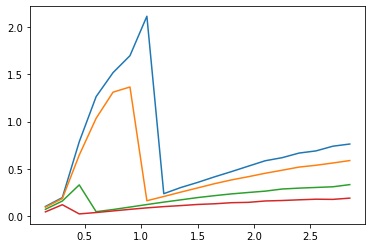

In [8]:
plt.plot(TNy15,Dy15)
plt.plot(TNy2,Dy2)
plt.plot(TNy4,Dy4)
plt.plot(TNy8,Dy8)

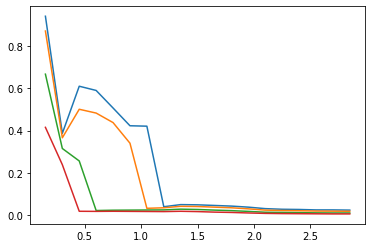

In [9]:
plt.plot(TNy15,Fybar15)
plt.plot(TNy2,Fybar2)
plt.plot(TNy4,Fybar4)
plt.plot(TNy8,Fybar8)